# Comparison - NWP and OF

**NWP: numerical weather predictions**

**OF: optical flow**

## Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import preprocessing

import os

from satprod.data_handlers.num_data import read_formatted_data_no_nan
from satprod.data_handlers.data_utils import sin_transform, cos_transform

In [193]:
def degrees(sin, cos):
    '''
    Converts sine and cosine of wind direction degrees into polar coordinate degrees.
    That is, 0 degrees means wind from west to east, 90 degrees means wind from
    south to nord, and so on.
    '''
    deg = np.zeros(len(cos))
    for i in range(len(cos)):
        if sin[i]>0:
            deg[i] = np.arcsin(cos[i])*180/np.pi
            if deg[i] < 0:
                deg[i] += 360
        elif cos[i]>0:
            deg[i] = np.arccos(sin[i])*180/np.pi
        else:
            deg[i] = np.arctan(cos[i]/sin[i])*180/np.pi+180
    return (deg+180) % 360

def getNumericalData(date: datetime) -> pd.DataFrame:
    enc_df, _ = read_formatted_data_no_nan(f'{root}/data/formatted')
    start = date + timedelta(hours=4)
    stop = date + timedelta(hours=21)
    data = enc_df.loc[start.strftime('%Y-%m-%d %H:%M:%S'):stop.strftime('%Y-%m-%d %H:%M:%S')].copy()
    parks = ['bess', 'skom', 'vals', 'yvik']
    for park in parks:
        data[f'wind_direction_sin_{park}'] = np.sin(np.pi*degrees(
            data[f'wind_direction_sin_{park}'], data[f'wind_direction_cos_{park}'])/180)
        data[f'wind_direction_cos_{park}'] = np.cos(np.pi*degrees(
            data[f'wind_direction_sin_{park}'], data[f'wind_direction_cos_{park}'])/180)
    return data

def getres(date: datetime):
    name = date.strftime('%Y-%m-%d-%H')
    path = f'/Users/jorgentaule/Desktop/Thesis/satprod/data/of_num_results/{name}-15min-20sc-dtvl1_dense.csv'
    of_res = pd.read_csv(path)
    of_res['time'] = of_res['Unnamed: 0']
    of_res['time'] = pd.to_datetime(of_res['time'])
    of_res = of_res.set_index('time')
    of_res = of_res.drop(columns=['Unnamed: 0'])
    of_res = of_res[3:].asfreq('H')

    of_deg_res = of_res[[col for col in of_res.columns if 'deg' in col]]
    for col in of_deg_res.columns:
        sin_tmp = np.sin(of_deg_res[col])
        cos_tmp = np.cos(of_deg_res[col])
        of_deg_res = of_deg_res.drop(columns=[col])
        of_deg_res[f'{col}_sin'] = sin_tmp
        of_deg_res[f'{col}_cos'] = cos_tmp
    of_res = of_res.drop(columns=[col for col in of_res.columns if 'deg' in col])
    of_res = pd.concat([of_res, of_deg_res], axis=1)
    return of_res

def getallres():
    of_res = pd.DataFrame()
    for date in pd.date_range(start=datetime(2019,6,3), end=datetime(2019,6,9), freq='D'):
        new_of_res = getres(date+timedelta(hours=3))
        of_res = pd.concat([of_res, new_of_res], axis=0)
    return of_res

def getAllData() -> pd.DataFrame:
    data = pd.DataFrame()
    for date in pd.date_range(start=datetime(2019,6,3), end=datetime(2019,6,9), freq='D'):
        new_data = getNumericalData(date)
        data = pd.concat([data, new_data], axis=0)
    of_res = getallres()
    of_dir_df = of_res[[col for col in of_res.columns if 'deg' in col]]
    of_mag_df = max_min_scale_df(of_res[[col for col in of_res.columns if 'mag' in col]])
    speed = max_min_scale_df(data[[col for col in data.columns if 'speed' in col]])
    prod = max_min_scale_df(data[[col for col in data.columns if 'prod' in col]])
    direction = data[[col for col in data.columns if 'direction' in col]]

    concat = pd.concat([of_dir_df, direction, of_mag_df, speed, prod], axis=1)
    return concat
    
def max_min_scale_df(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index = df.index, columns=df.columns)

In [195]:
data = getAllData()

In [201]:
data.columns

Index(['vals_deg_pixel_sin', 'vals_deg_pixel_cos', 'yvik_deg_pixel_sin',
       'yvik_deg_pixel_cos', 'bess_deg_pixel_sin', 'bess_deg_pixel_cos',
       'skom_deg_pixel_sin', 'skom_deg_pixel_cos', 'vals_deg_median_sin',
       'vals_deg_median_cos', 'yvik_deg_median_sin', 'yvik_deg_median_cos',
       'bess_deg_median_sin', 'bess_deg_median_cos', 'skom_deg_median_sin',
       'skom_deg_median_cos', 'wind_direction_cos_bess',
       'wind_direction_sin_bess', 'wind_direction_cos_skom',
       'wind_direction_sin_skom', 'wind_direction_cos_vals',
       'wind_direction_sin_vals', 'wind_direction_cos_yvik',
       'wind_direction_sin_yvik', 'vals_mag_pixel', 'yvik_mag_pixel',
       'bess_mag_pixel', 'skom_mag_pixel', 'vals_mag_median',
       'yvik_mag_median', 'bess_mag_median', 'skom_mag_median',
       'wind_speed_bess', 'wind_speed_skom', 'wind_speed_vals',
       'wind_speed_yvik', 'production_bess', 'production_skom',
       'production_vals', 'production_yvik'],
      dtype='objec

In [218]:
parks = ['bess', 'skom', 'vals', 'yvik']
for park in parks:
    park_data = data[[col for col in data.columns if park in col]]
    sin_data = park_data[[col for col in park_data.columns if 'sin' in col]]
    cos_data = park_data[[col for col in park_data.columns if 'cos' in col]]
    break

In [230]:
pd.concat([park_data[[col for col in park_data.columns if 'mag' in col]], 
            park_data[f'wind_speed_{park}'], 
            park_data[f'production_{park}']], axis = 1)

,bess_mag_pixel,bess_mag_median,wind_speed_bess,production_bess
time,,,,
2019-06-03 04:00:00,0.350770,0.346108,0.591047,0.576110
2019-06-03 05:00:00,0.422167,0.418528,0.636094,0.625608
2019-06-03 06:00:00,0.281313,0.280533,0.678973,0.574993
2019-06-03 07:00:00,0.266828,0.265918,0.612080,0.415409
2019-06-03 08:00:00,0.242801,0.241162,0.592696,0.439018
...,...,...,...,...
2019-06-09 17:00:00,0.098823,0.098231,0.407206,0.052222
2019-06-09 18:00:00,0.131023,0.120856,0.365429,0.089031
2019-06-09 19:00:00,0.177904,0.169951,0.422802,0.308237


In [228]:
park_data[[col for col in park_data.columns if 'speed' in col]]

,wind_speed_bess
time,
2019-06-03 04:00:00,0.591047
2019-06-03 05:00:00,0.636094
2019-06-03 06:00:00,0.678973
2019-06-03 07:00:00,0.612080
2019-06-03 08:00:00,0.592696
...,...
2019-06-09 17:00:00,0.407206
2019-06-09 18:00:00,0.365429
2019-06-09 19:00:00,0.422802


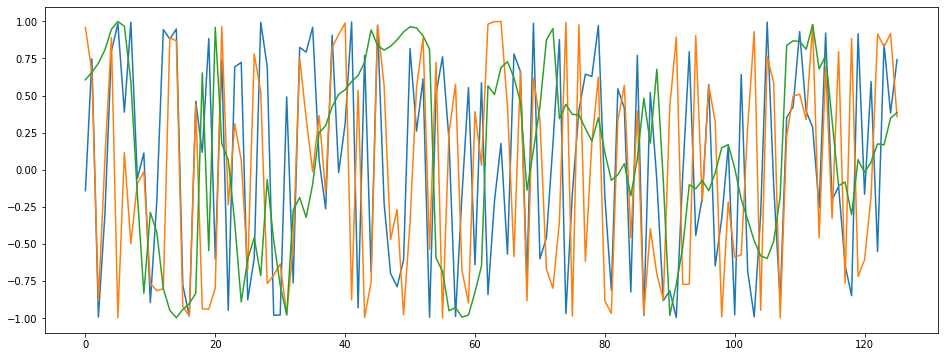

In [222]:
plt.figure(figsize=(16,6))
plt.plot(sin_data[f'{park}_deg_pixel_sin'].values)
plt.plot(sin_data[f'{park}_deg_median_sin'].values)
plt.plot(sin_data[f'wind_direction_sin_{park}'].values)

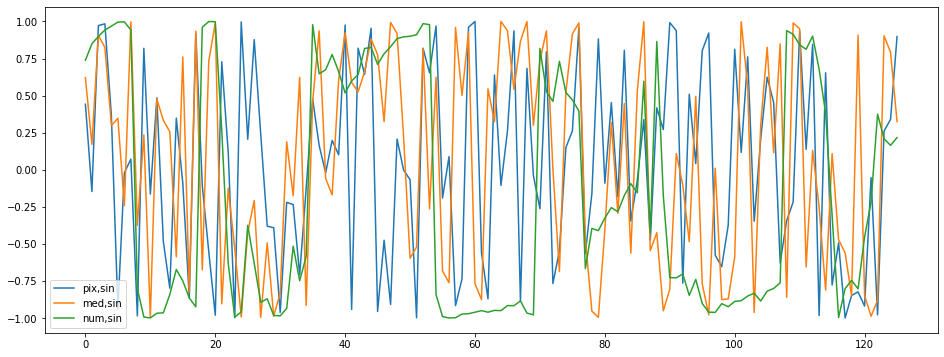

In [224]:
plt.figure(figsize=(16,6))
plt.plot(data.vals_deg_pixel_sin.values, label='pix,sin')
plt.plot(data.vals_deg_median_sin.values, label='med,sin')
plt.plot(data.wind_direction_sin_vals.values, label='num,sin')
plt.legend()
plt.show()

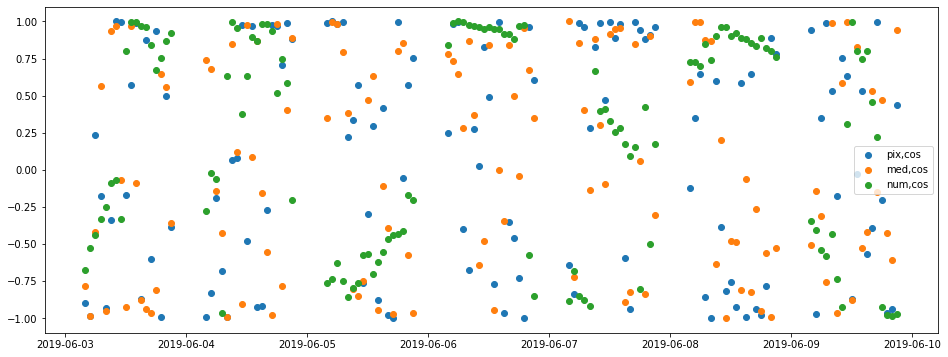

In [217]:
plt.figure(figsize=(16,6))
plt.scatter(data.index, data.vals_deg_pixel_cos, label='pix,cos')
plt.scatter(data.index, data.vals_deg_median_cos, label='med,cos')
plt.scatter(data.index, data.wind_direction_cos_vals, label='num,cos')
plt.legend()
plt.show()

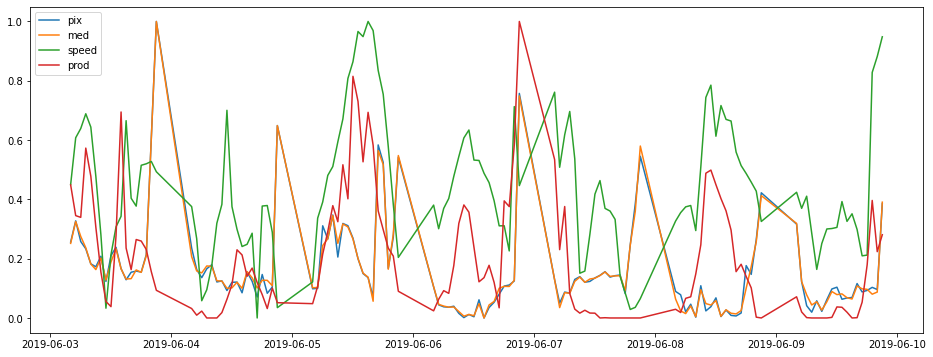

In [208]:
plt.figure(figsize=(16,6))
plt.plot(data.vals_mag_pixel, label='pix')
plt.plot(data.vals_mag_median, label='med')
plt.plot(data.wind_speed_vals, label='speed')
plt.plot(data.production_vals, label='prod')
plt.legend()
plt.show()

In [213]:
np.sqrt(np.mean(np.square(data.vals_mag_median.values-data.wind_speed_vals.values)))of

0.3880816046068959

## Configs

In [61]:
%%capture
# root directory
root = '..'

# paths to optical flow results
#direction_path = os.path.join(root, 'data', 'direction_dfs')
#magnitude_path = os.path.join(root, 'data', 'magnitude_dfs')
path = os.path.join(root, 'data', 'of_num_results')

# tests are done only for this specific week
start = '2019-06-03 00:00:00'
stop = '2019-06-09 23:00:00'

# get data and store in variable 'data'
enc_df, _ = read_formatted_data_no_nan(f'{root}/data/formatted')
data = enc_df.loc[start:stop]

def degrees(sin, cos):
    '''
    Converts sine and cosine of wind direction degrees into polar coordinate degrees.
    That is, 0 degrees means wind from west to east, 90 degrees means wind from
    south to nord, and so on.
    '''
    deg = np.zeros(len(cos))
    for i in range(len(cos)):
        if sin[i]>0:
            deg[i] = np.arcsin(cos[i])*180/np.pi
            if deg[i] < 0:
                deg[i] += 360
        elif cos[i]>0:
            deg[i] = np.arccos(sin[i])*180/np.pi
        else:
            deg[i] = np.arctan(cos[i]/sin[i])*180/np.pi+180
    return (deg+180) % 360

def get_polar_directions(data: pd.DataFrame, park: str, day: int=0, all_days: bool=False):
    if all_days==False:
        assert day>=0, 'day needs to be a positive number'
        assert day<7, 'day needs to be within a week'
    
        sin = data[f'wind_direction_sin_{park}'].iloc[day*24:day*24+24].values
        cos = data[f'wind_direction_cos_{park}'].iloc[day*24:day*24+24].values
    else:
        sin = data[f'wind_direction_sin_{park}'].values
        cos = data[f'wind_direction_cos_{park}'].values
    return degrees(sin, cos)

# drop production data
data = data.drop(columns=[col for col in data.columns if 'prod' in col])

# convert to polar degrees
for park in parks:
    polar_directions = get_polar_directions(data, park, all_days=True)
    data[f'wind_direction_sin_{park}'] = np.sin(polar_directions*np.pi/180)
    data[f'wind_direction_cos_{park}'] = np.cos(polar_directions*np.pi/180)

def max_min_scale_df(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index = df.index, columns=df.columns)
speed = max_min_scale_df(data[[col for col in data.columns if 'speed' in col]])
direction = data[[col for col in data.columns if 'direction' in col]]
# parknames
parks = ['bess', 'skom', 'vals', 'yvik']

# starttimes
starttimes = []
for i in range(3, 10):
    starttimes.append(datetime(2019, 6, i, 3))

starttimes_str = []
for date in starttimes:
    starttimes_str.append(date.strftime('%Y-%m-%d-%H'))

## Functions

In [76]:
def get_OF_results(path, imgType):
    df = pd.DataFrame()
    for date in starttimes:
        name = date.strftime('%Y-%m-%d-%H') + f'-15min-20sc-{imgType}.csv'
        df_new = pd.read_csv(f'{path}/{name}')
        df_new['time'] = pd.to_datetime(df_new['Unnamed: 0'])
        df_new = df_new.set_index(['time'])
        df_new = df_new.drop(columns=['Unnamed: 0'])
        df = pd.concat([df, df_new], axis=0)
    df2 = pd.DataFrame(index = pd.date_range(start, stop, freq='15T'))
    df3 = pd.merge(df2, df, left_index = True, right_index = True, how = 'left')
    #df3 = df3.interpolate(limit_direction='both')
    for hour in [4, 19, 20, 21]:
        df3.loc[df3.index.hour==hour] = np.nan
    for park in parks:
        for meas in ['pixel', 'median']:
            df3[f'{park}_deg_{meas}_sin'] = np.sin(df3[f'{park}_deg_{meas}'].values*np.pi/180)
            df3[f'{park}_deg_{meas}_cos'] = np.cos(df3[f'{park}_deg_{meas}'].values*np.pi/180)
            df3 = df3.drop(columns=[f'{park}_deg_{meas}'])
    df3[[col for col in df3.columns if 'mag' in col]] = max_min_scale_df(df3[[col for col in df3.columns if 'mag' in col]])
    return df3.asfreq('H')

In [79]:
def get_bess_plots(imgType):
    of_res = get_OF_results(path, imgType)
    df = pd.concat([of_res, speed, direction], axis=1)
    
    plt.figure(figsize=(16,4))
    plt.title('cos')
    df.bess_deg_median_cos.plot()
    df.wind_direction_cos_bess.plot()
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title('sin')
    df.bess_deg_median_sin.plot()
    df.wind_direction_sin_bess.plot()
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title('speed')
    df.bess_mag_median.plot()
    df.wind_speed_bess.plot()
    plt.show()

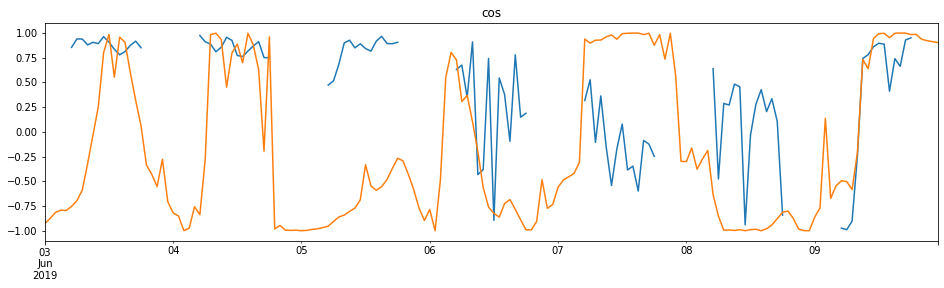

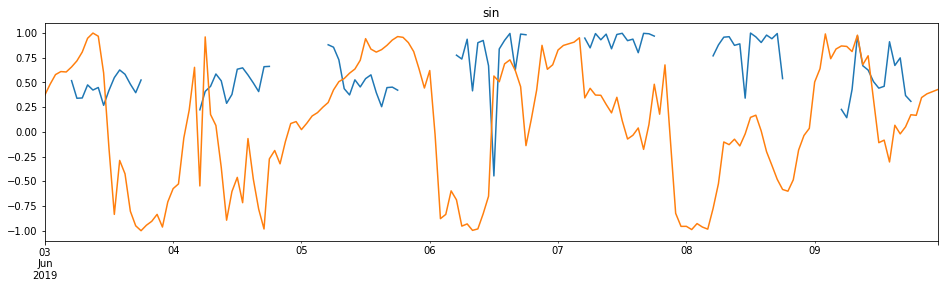

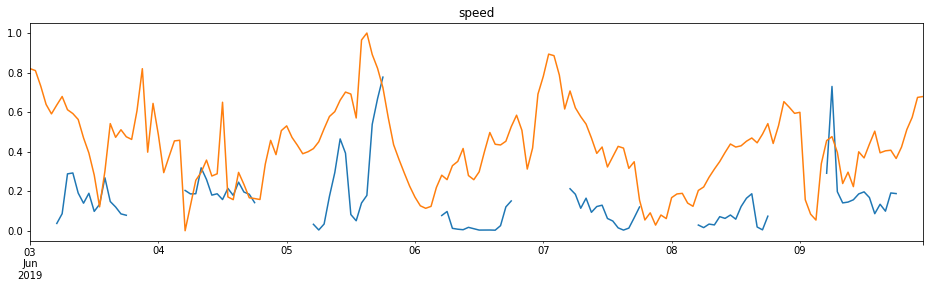

In [80]:
get_bess_plots('fb_dense')

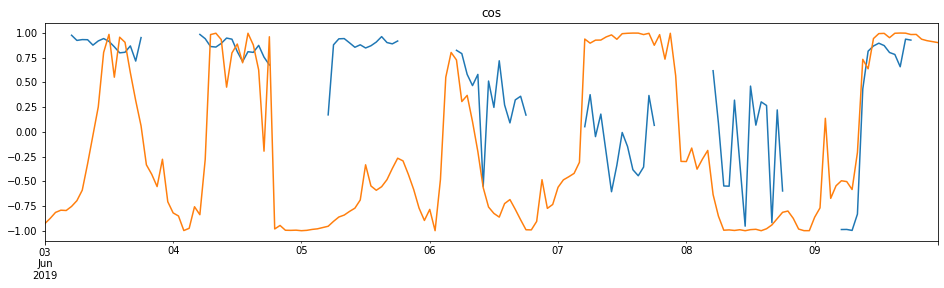

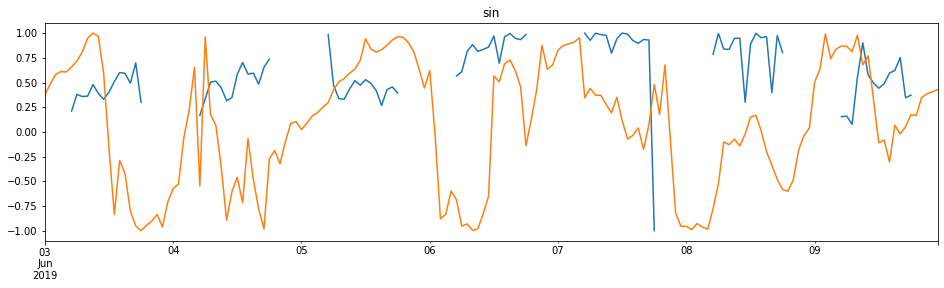

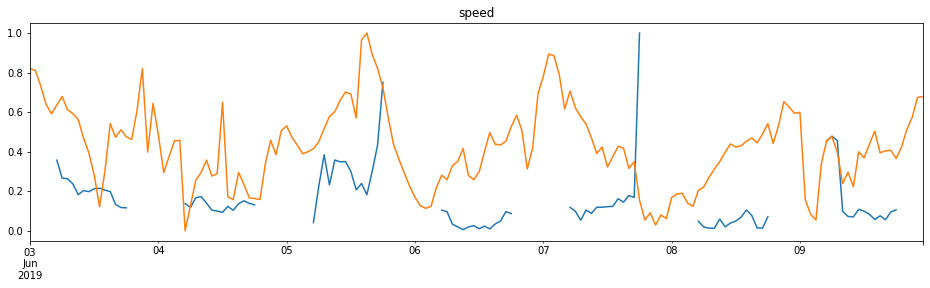

In [81]:
get_bess_plots('lk_dense')

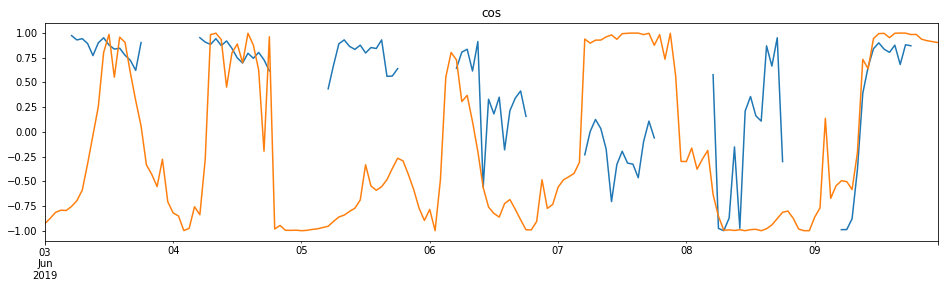

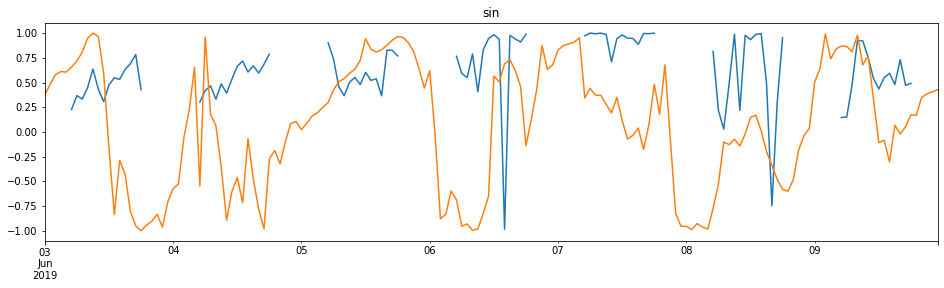

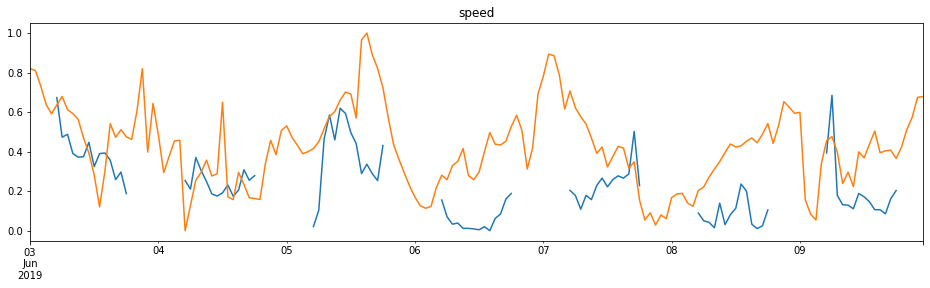

In [82]:
get_bess_plots('dtvl1_dense')

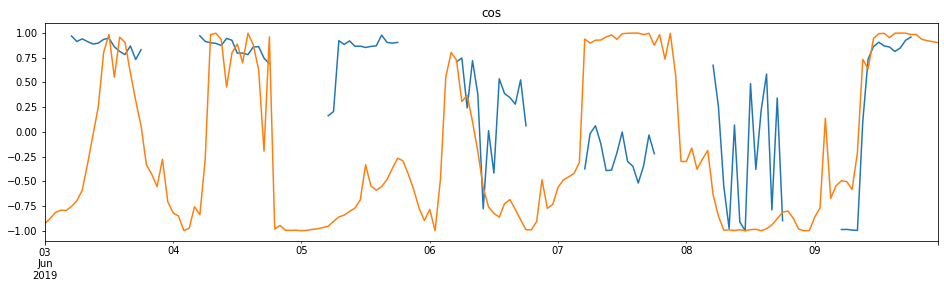

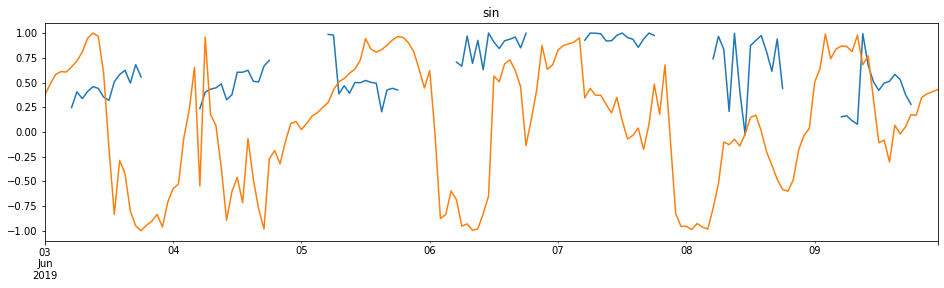

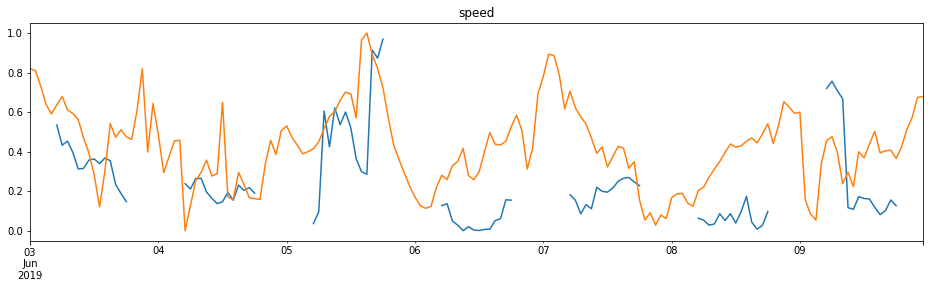

In [83]:
get_bess_plots('rlof_dense')

In [92]:
def get_bess_all_in_one():
    plt.figure(figsize=(16,4))
    plt.title('cos')
    of_res = get_OF_results(path, 'fb_dense')
    plt.plot(of_res.bess_deg_median_cos.values, label='fb')
    plt.plot(direction.wind_direction_cos_bess.values, label='nwp')
    
    of_res = get_OF_results(path, 'lk_dense')
    plt.plot(of_res.bess_deg_median_cos.values, label='lk')
    
    of_res = get_OF_results(path, 'dtvl1_dense')
    plt.plot(of_res.bess_deg_median_cos.values, label='dtvl1')
    
    of_res = get_OF_results(path, 'rlof_dense')
    plt.plot(of_res.bess_deg_median_cos.values, label='rlof')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title('sin')
    of_res = get_OF_results(path, 'fb_dense')
    plt.plot(of_res.bess_deg_median_sin.values, label='fb')
    plt.plot(direction.wind_direction_cos_bess.values, label='nwp')
    
    of_res = get_OF_results(path, 'lk_dense')
    plt.plot(of_res.bess_deg_median_sin.values, label='lk')
    
    of_res = get_OF_results(path, 'dtvl1_dense')
    plt.plot(of_res.bess_deg_median_sin.values, label='dtvl1')
    
    of_res = get_OF_results(path, 'rlof_dense')
    plt.plot(of_res.bess_deg_median_sin.values, label='rlof')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title('speed')
    of_res = get_OF_results(path, 'fb_dense')
    plt.plot(of_res.bess_mag_median.values, label='fb')
    plt.plot(speed.wind_speed_bess.values, label='nwp')
    
    of_res = get_OF_results(path, 'lk_dense')
    plt.plot(of_res.bess_mag_median.values, label='lk')
    
    of_res = get_OF_results(path, 'dtvl1_dense')
    plt.plot(of_res.bess_mag_median.values, label='dtvl1')
    
    of_res = get_OF_results(path, 'rlof_dense')
    plt.plot(of_res.bess_mag_median.values, label='rlof')
    plt.legend()
    plt.show()

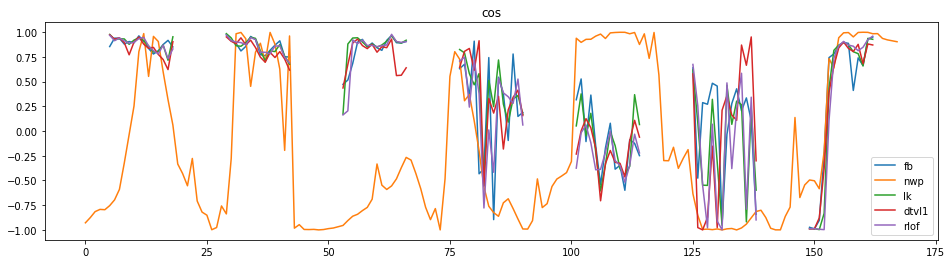

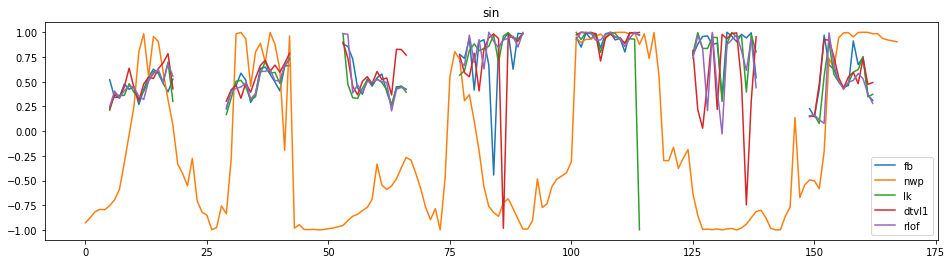

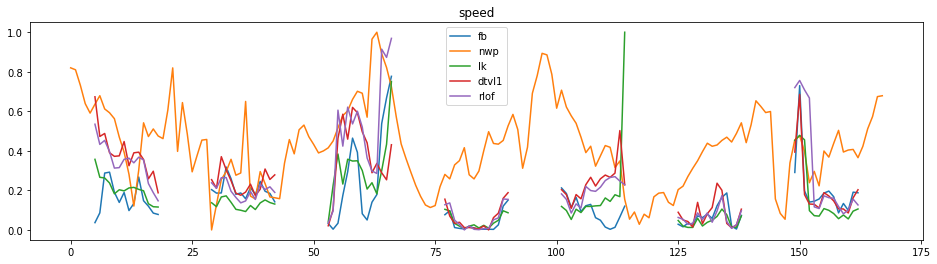

In [93]:
get_bess_all_in_one()

In [3]:
# get original degree values
def get_degree_NWP(park):
    '''
    A function to see the raw values in order to check that the
    processing of these hasn't changed their meaning.
    
    Input parameters:
        park: can either be 'bess', 'yvik', 'skom', or 'vals'
    
    Output:
        df: dataframe containing direction values for the given park in degrees
    '''
    
    path = os.path.join(root, 'data', 'num')
    df = pd.read_csv(f'{path}/{park}_weather.csv')

    df = df[['date_forecast', 'wind_direction']]

    df.date_forecast = pd.to_datetime(df.date_forecast)
    df = df.set_index(['date_forecast'])

    df = df[~df.index.duplicated(keep='last')]

    return df

def plot_direction_arrows(direction, day):
    X, Y = np.meshgrid(np.arange(len(direction)), np.arange(1))
    U = cos_transform(direction)
    V = sin_transform(direction)

    plt.figure(figsize=(16,2))
    plt.quiver(X, Y, U, V, scale=40, headaxislength=2, headlength=3)
    plt.xlabel('hour of the day')
    plt.ylabel(starttimes_str[day])
    #plt.yticks(np.arange(0), starttimes_str[day])
    plt.xticks(np.arange(24))
    plt.yticks([], [])
    plt.title(f'Numerically predicted wind directions at {park}')
    plt.show()


def plot_direction_comparison(all_dir: pd.DataFrame, park: str, trig: str):
    df = all_dir[[col for col in all_dir.columns if trig in col]]
    df = df[[col for col in df.columns if park in col]]
    plt.figure(figsize=(16,4))
    plt.plot(df[df.columns[0]].values, label=df.columns[0])
    plt.plot(df[df.columns[1]].values, label=df.columns[1])
    plt.title(f'{trig} of optical flow calculated wind direction at {park}')
    plt.ylabel(f'{trig} of angle')
    plt.xlabel('hours')
    plt.legend()
    plt.show()
    
def get_all_dir_df(of_dirs: pd.DataFrame, data: pd.DataFrame):
    # direction dataframe with sines and cosines for img data
    dir_df = pd.DataFrame(index=of_dirs.index)
    for park in parks:
        dir_df[f'of_wind_direction_{park}_sin'] = np.sin(of_dirs[f'of_wind_direction_{park}'].values*np.pi/180)
        dir_df[f'of_wind_direction_{park}_cos'] = np.cos(of_dirs[f'of_wind_direction_{park}'].values*np.pi/180)

    # direction dataframe of sines and cosines with corrected degree value for nwp
    dir_df_nwp = pd.DataFrame(index=data.index)
    for park in parks:
        polar_directions = get_polar_directions(data, park, all_days=True)
        dir_df_nwp[f'wind_direction_sin_{park}'] = np.sin(polar_directions*np.pi/180)
        dir_df_nwp[f'wind_direction_cos_{park}'] = np.cos(polar_directions*np.pi/180)

    # the data concatenated
    return pd.concat([dir_df, dir_df_nwp], axis=1)

def plot_magnitude_comparison(all_mag: pd.DataFrame, park: str):
    plt.figure(figsize=(16,4))
    plt.plot(all_mag[f'of_wind_magnitude_{park}'], label='img')
    plt.plot(all_mag[f'production_{park}'], label='nwp')
    plt.legend()
    plt.title(f'production and optical flow magnitude at {park}')
    plt.xlabel('date')
    plt.ylabel('magnitude/production normalised')
    plt.show()
    
def get_scaled_all_mag_df(prod: pd.DataFrame):
    of_mags = get_OF_results(magnitude_path)
    prod = max_min_scale_df(prod)
    of_mags = max_min_scale_df(of_mags)
    return pd.concat([prod, of_mags], axis=1)

## Results

### Direction

#### Plot arrows of numerically predicted directions and compare to cloud videos

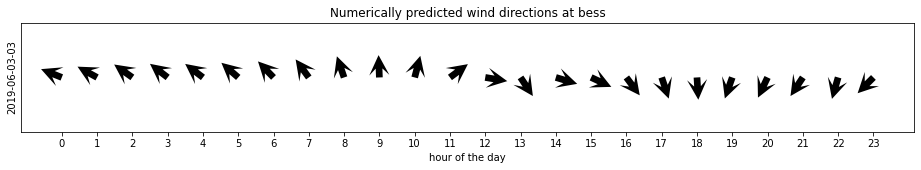

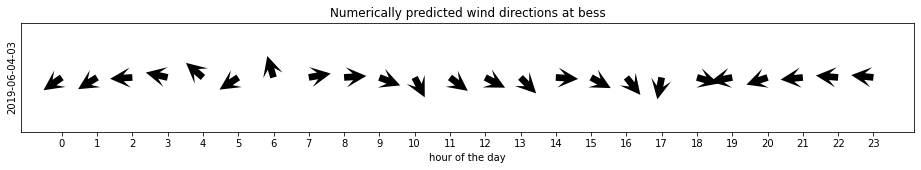

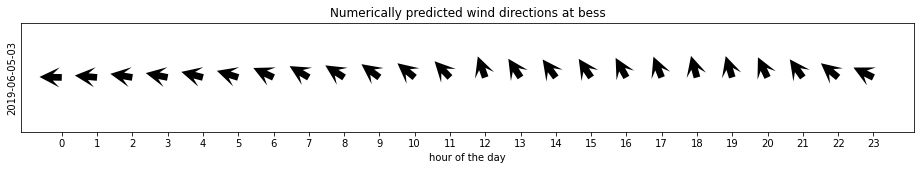

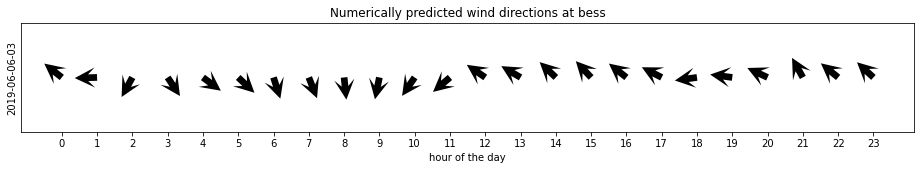

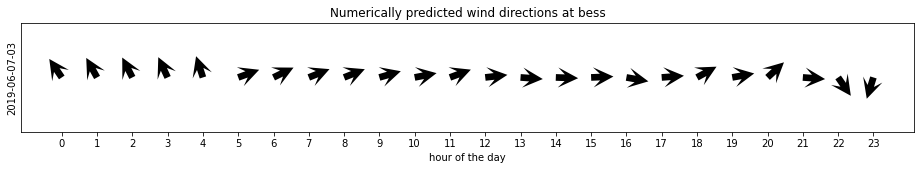

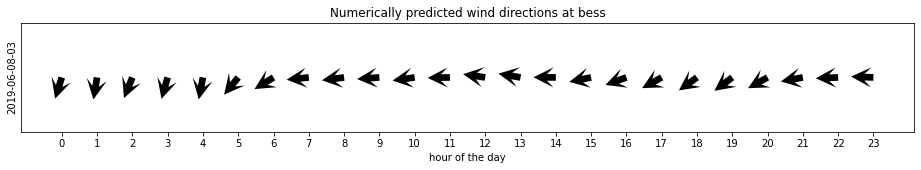

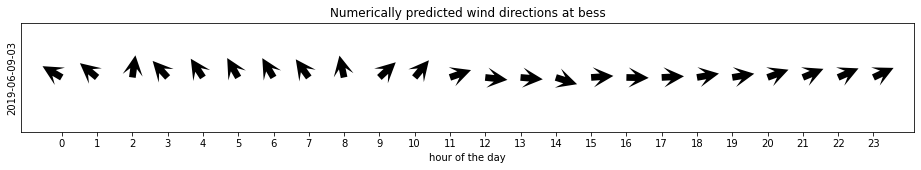

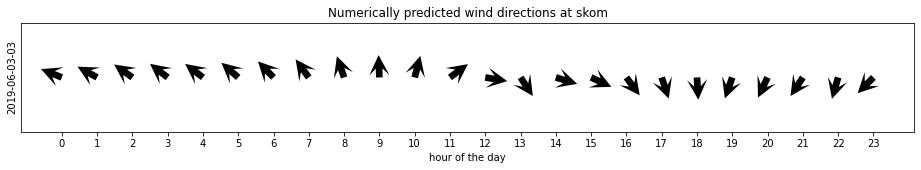

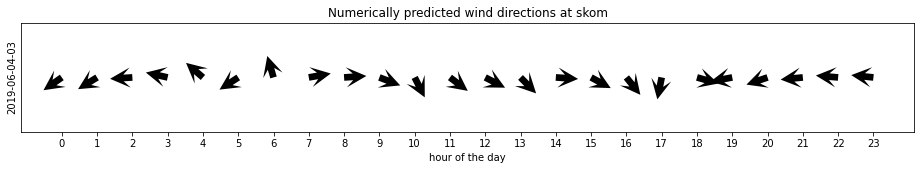

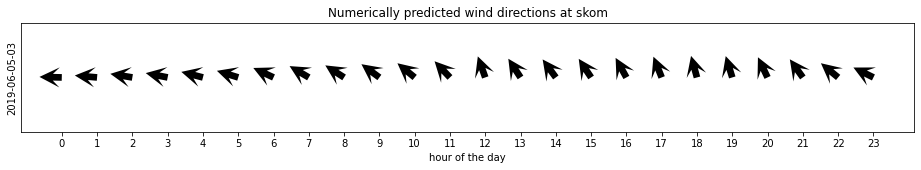

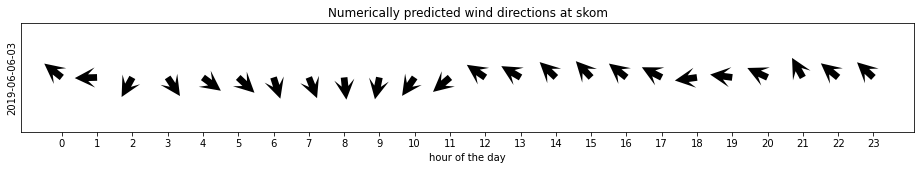

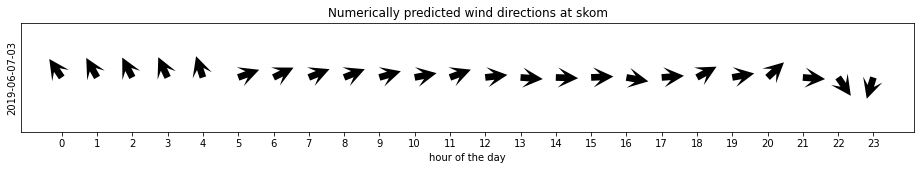

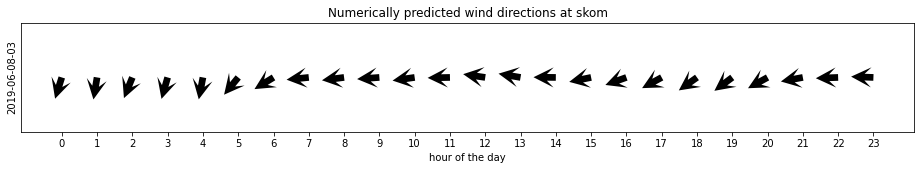

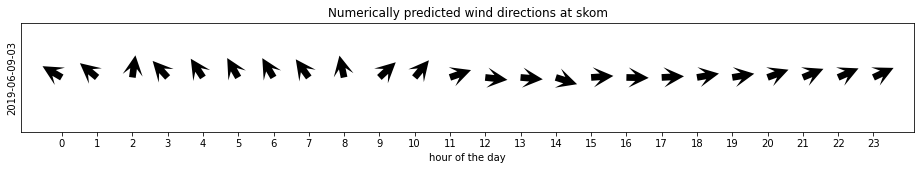

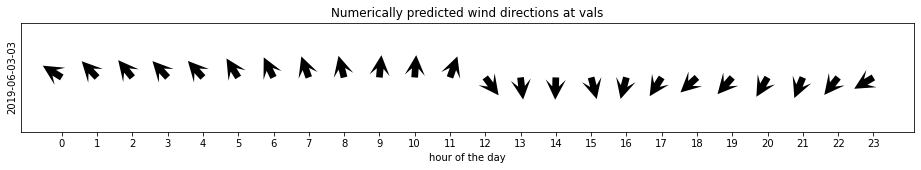

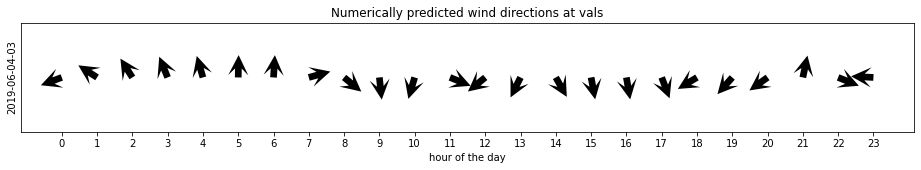

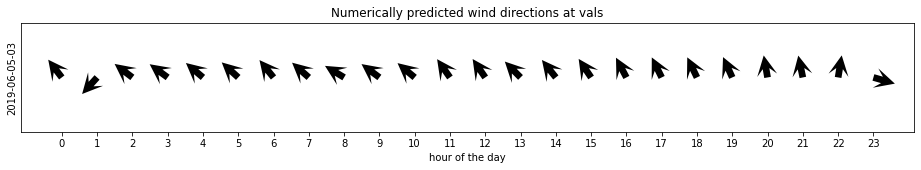

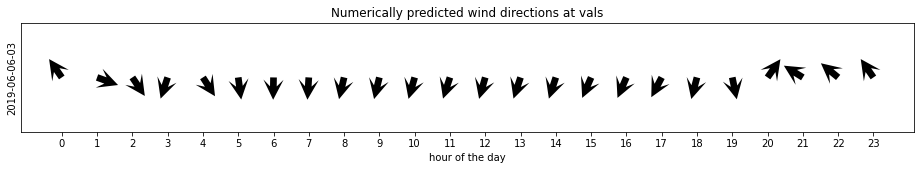

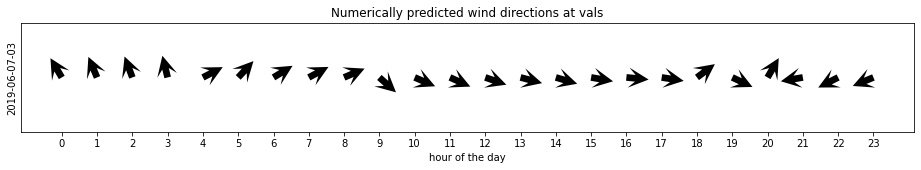

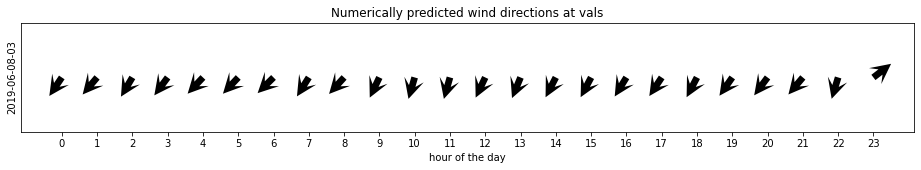

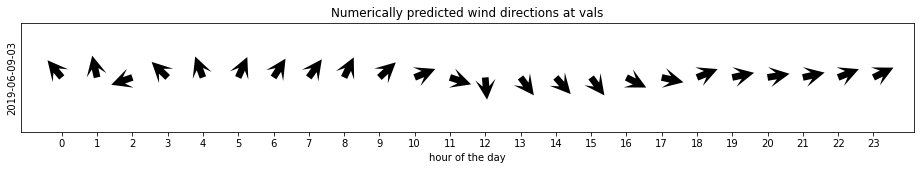

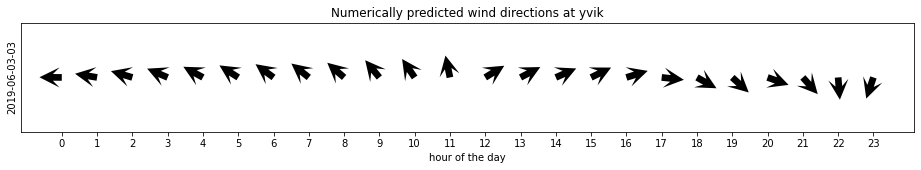

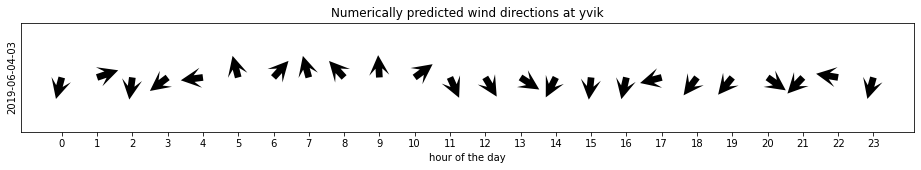

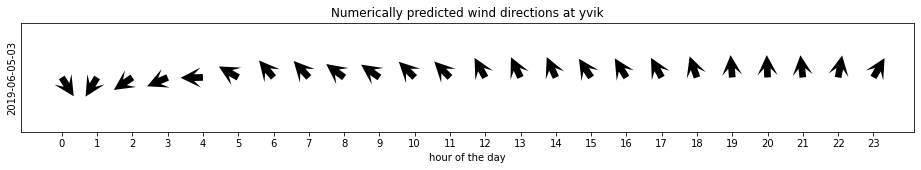

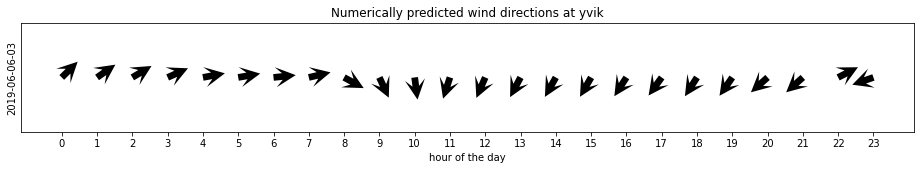

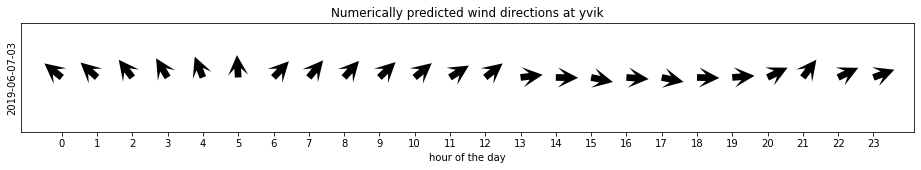

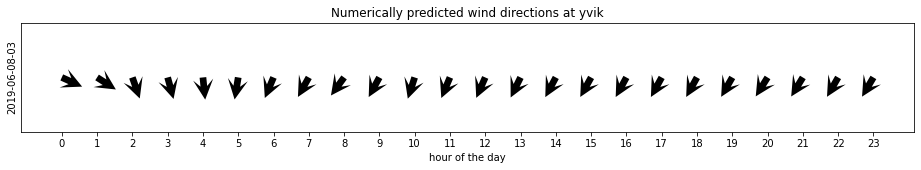

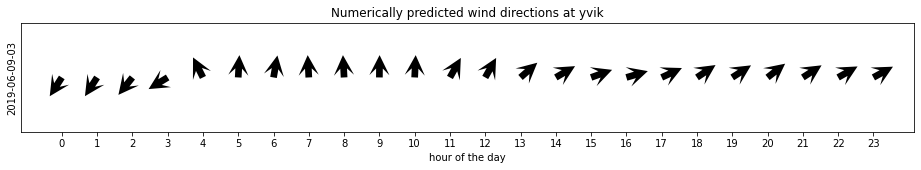

In [4]:
for park in parks:
    for day in np.arange(7):
        dirs = get_polar_directions(data, park, day)
        plot_direction_arrows(dirs, day)

#### Plot cosine and sine of directions on a timescale for both of and nwp, and compare

In [5]:
of_dirs = get_OF_results(direction_path)
all_dir = get_all_dir_df(of_dirs, data)

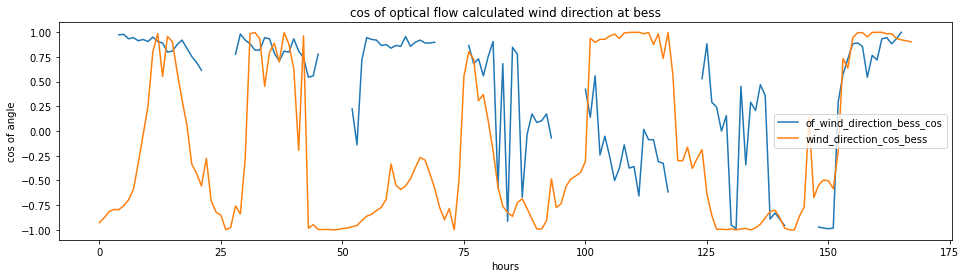

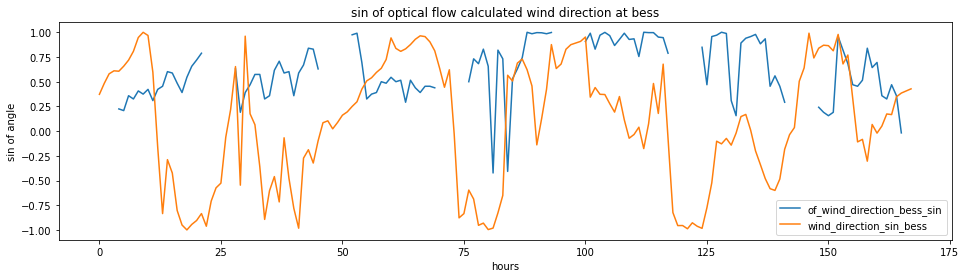

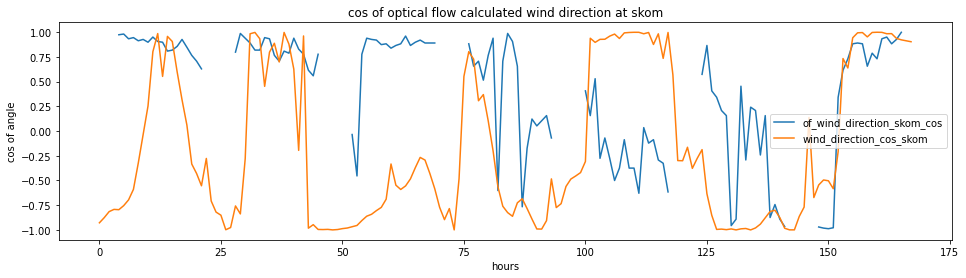

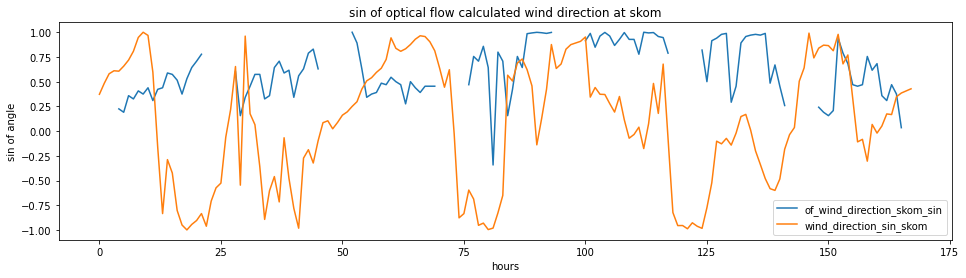

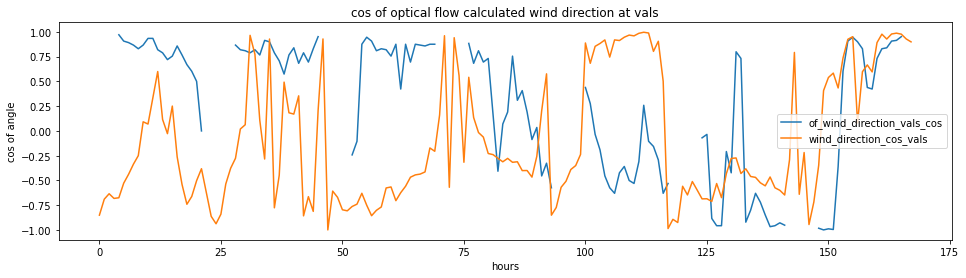

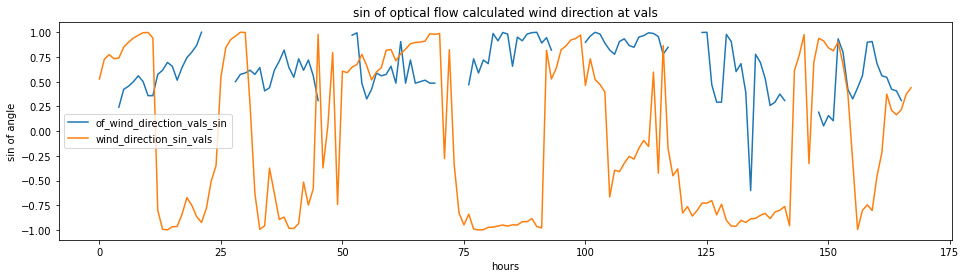

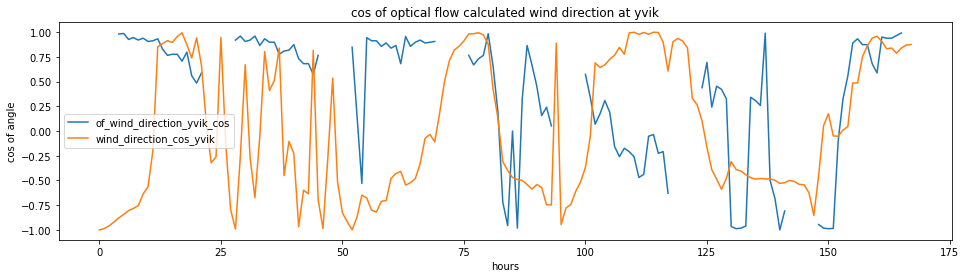

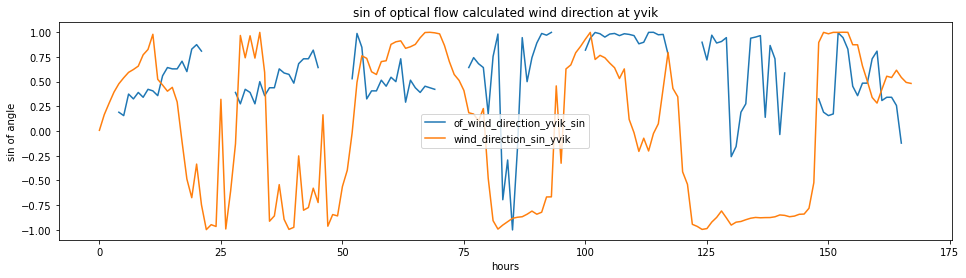

In [6]:
for park in parks:
    for trig in ['cos','sin']:
        plot_direction_comparison(all_dir, park, trig)

#### Heatmap of cosine and sine values separately

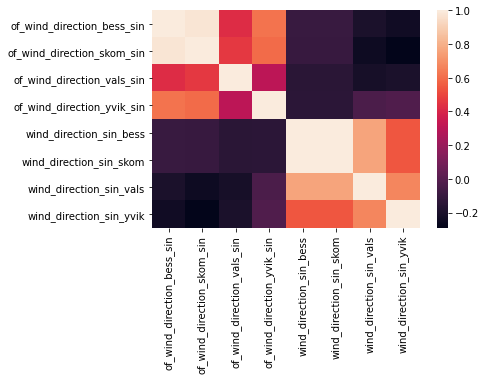

In [7]:
sns.heatmap(all_dir[[col for col in all_dir.columns if 'sin' in col]].dropna(axis=0).corr())
plt.show()

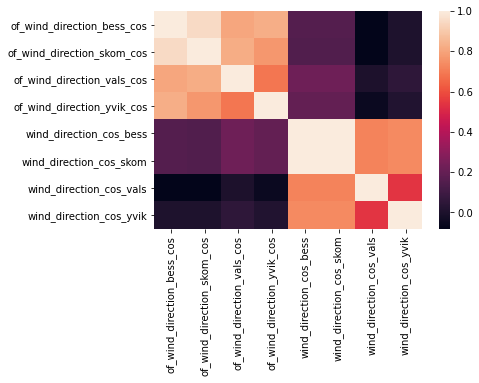

In [8]:
sns.heatmap(all_dir[[col for col in all_dir.columns if 'cos' in col]].dropna(axis=0).corr())
plt.show()

### Magnitude

Blurring is used in the optical flow algoithm in order to capture the general direction of the clouds. However, if there's an area beside the parks or a point in time where the parks are not covered by clouds, the blurring may give a false value that is somewhere between zero and the measurement in the nearby area with moving clouds. Another way to describe this problem is that the algorithm doesn't give zero (an easy to spot should-be-nan value), when it should.

In [9]:
all_mag = get_scaled_all_mag_df(prod)

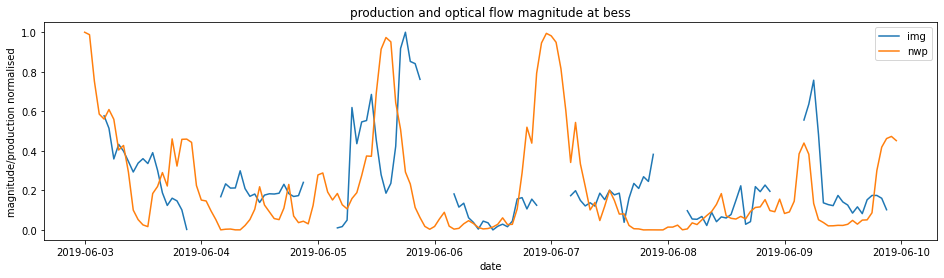

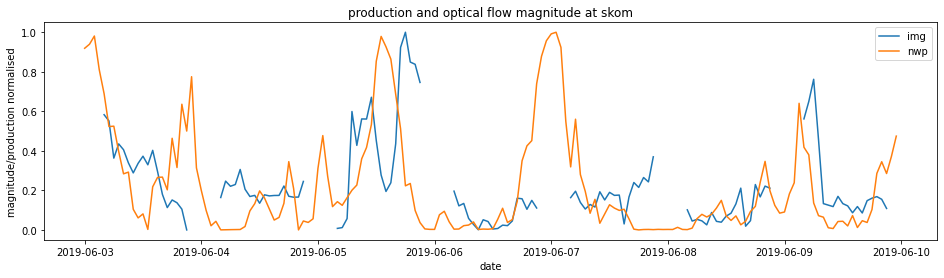

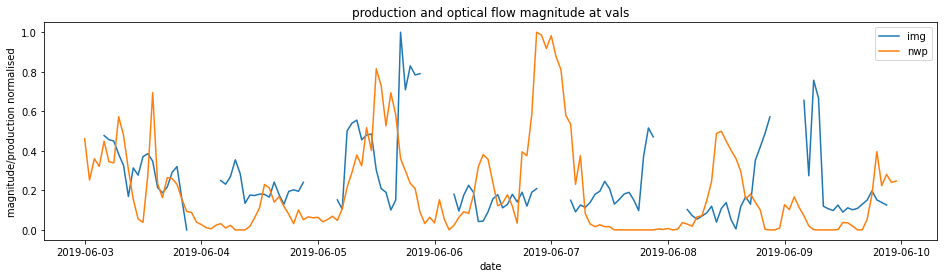

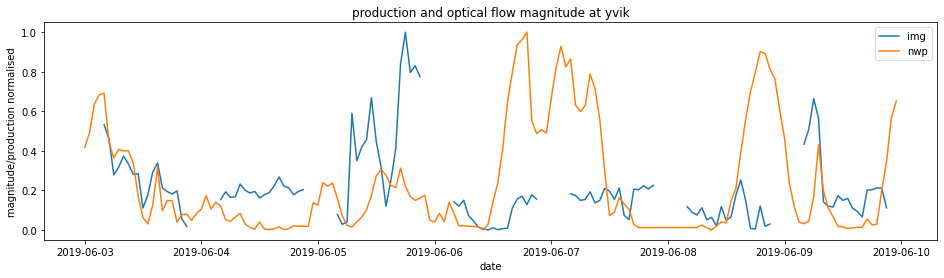

In [10]:
for park in parks:
    plot_magnitude_comparison(all_mag, park)

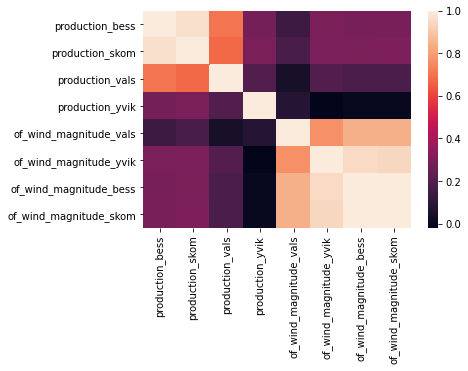

In [11]:
sns.heatmap(all_mag.dropna(axis=0).corr())
plt.show()